# Modelo de classificação do Titanic - EDA

Nesse Jupyter Notebook se encontram as etapas e conclusões intermediárias do desafio de data science do programa Lighthouse da Indicium. Para isso, a base de dados foi disponibilizada via [Kaggle](https://www.kaggle.com/competitions/titanic/overview).

Esse desafio consiste em analisar os dados a respeito dos passageiros do Titanic, navio que afundou em 1912, durante a sua viagem inaugural. Como haviam poucos barcos salva-vidas a bordo, 1502 pessoas faleceram, entre passageiros e tripulantes.

Após a análise dos dados, será desenvolvido um modelo de machine learning capaz de prever se um passageiro sobreviveu ou não ao acidente.

## Importando os arquivos e analisando os dados

Antes de iniciar o projeto, é necessário instalar algumas bibliotecas.

In [3]:
!pip install seaborn

In [4]:
!pip install -U scikit-learn

In [5]:
!pip install xgboost

Com as bibliotecas instaladas, é possível importar os dados de treino para que eles sejam analisados e preparados para o modelo de machine learning.

In [6]:
import pandas as pd

In [7]:
catalog.list()

['training_dataset', 'test_dataset', 'parameters']

In [8]:
df = catalog.load('training_dataset')

[02/22/23 20:10:57] INFO     Loading data from 'training_dataset' (CSVDataSet)...               data_catalog.py:343

In [9]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Os dados foram importados com sucesso. Com o método `head()` é possível ver que em alumas colunas há valores nulos que precisam ser analisados com cuidado. Para entender melhor as informações de cada coluna e quais colunas possuem valores nulos, pode-se usar o método `info()`

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Para a análise inicial, podemos cruzar as informações já vistas com o dicionário que foi disponibilizado junto com os dados:
    
Variável|Definição|Key
--------|----------|---
survival|Indica se o passageiro sobreviveu|0 = Não, 1 = Sim
pclass|Classe do passageiro|1 = Primeira, 2 = Segunda, 3 = Terceira
sex|Genero|
Age|Idade em anos|
sibsp|número de parentes/cônjuges a bordo do Titanic|
parch|numero de pais/filhos a bordo do Titanic|
ticket|Número do ticket|
fare|Valor pago pelo passageiro|
cabin|Número da cabine|
embarked|Porto de embarque|C = Cherbourg, Q = Queenstown, S = Southampton  

Após a aplicação dos métodos, em conjunto com as descrições encontradas no dicionário de dados, é possível afirmar que:

1 - As variáveis `Age`, `Cabin` e `Embarked` possuem informações nulas. Essa colunas deverão ser analizadas mais profundamente para entender o motivo.

2 - A variável `PassengerId` contém informações únicas para todas as linhas e não será útil em análises, por isso ela será removida do DataFrame. A *feature* `Ticket` também parece conter informações únicas e será analisada mais a fundo.

3 - As colunas `SibSp` e `Parch` contém informações sobre a quantidade de familiares. Análises posteriores serão efetuadas para a possibilidade de união das duas colunas.

4 - A variável `Name` possui, além do nome, informações a respeito de títulos de cada passageiro. Essa variável será analizada para entender se o título poderá ser utilizado como uma feature nova.

5 - Há variáveis numéricas discretas e variáveis categóricas. As variáveis categóricas deverão ser tratadas durante a etapa de *feature engeneering*.

## Entendendo as colunas

### `PassengerId`, `Ticket` e `Cabin`

Primeiro vamos remover a coluna `PassengerId`, que não será aproveitada:

In [11]:
df = df.drop(columns = 'PassengerId')

Podemos também analisar a coluna `Ticket`:

In [12]:
df['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

A coluna possui valores repetidos, mostrando que alguns tickets serviram para múltiplos passageiros. Porém, ainda há um grande número de tickets únicos, por isso a coluna também será excluída.

In [13]:
df = df.drop(columns = 'Ticket')

Outra coluna que pode ser analisada para remoção é a coluna `Cabin`. Após a analise do método `info()`, foi percebido que ela possui mais valores nulos que informações sobre as cabines.

In [14]:
df['Cabin'].isnull().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

Realmente há mais valores nulos que informações sobre as cabines. Como as informações faltantes não parecem ser inferidas, essa coluna será removida.

In [15]:
df = df.drop(columns = 'Cabin')

Após a remoção dessas colunas indejesadas, é possível analisar as outras colunas presentes no dataset

### Colunas `Age` e `Embarked`

Primeiramente vamos olhar para a coluna `Embarked`, que sinaliza o porto de embarque de cada passageiro.

In [16]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Na análise com o método `info()`, foram descobertos valores nulos. Vamos pegar apenas esses registros e verificar:

In [17]:
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


Podemos verificar como é a distribuição de sobreviventes entre portos, para saber se há a necessidade de manter essa coluna.

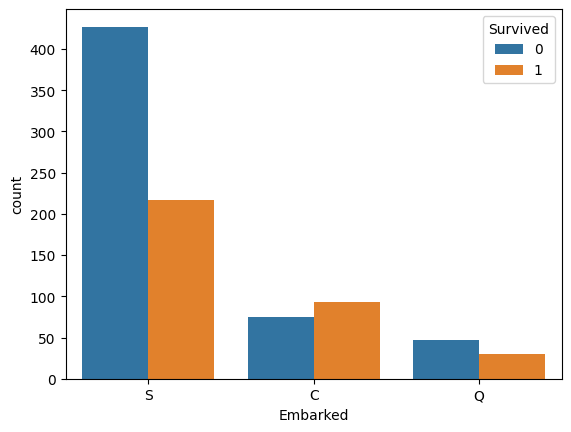

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data = df, x = 'Embarked', hue = 'Survived')

Como a coluna apresenta uma distribuição diferente para cada porto, é interessante manter essa coluna para análises futuras. As linhas que possuem valores nulos serão removidas das análises futuras.

In [20]:
df = df[df.Embarked.notnull()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       712 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Fare      889 non-null    float64
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


Com as linhas removidas, podemos analisar a coluna `Age`, que também possui valores nulos.

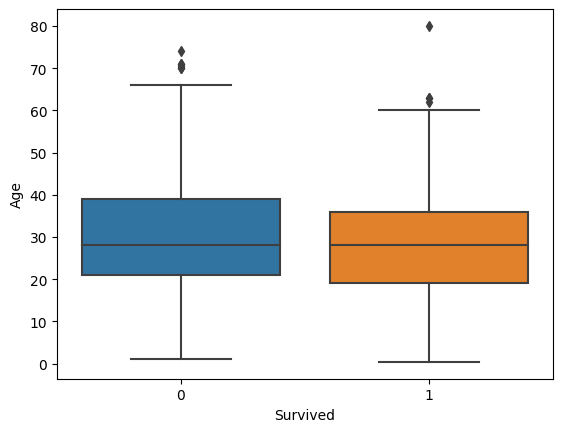

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.boxplot(data = df, y = 'Age', x = 'Survived')

Analisando o gráfico se percebe uma pequena diferença entre as distribuições das idades de quem sobreviveu ou não. Essa diferença, no entanto, não parece ser acentuada. Os valores faltantes na coluna serão substituídos pela média de idade do grupo que a pessoa pertence: se sobreviveu ou não.

In [22]:
## botando a média de idade

sobreviveram = df.query('Survived == 1')
nao_sobreviveram = df.query('Survived == 0')

In [23]:
media_sobreviveram = sobreviveram['Age'].mean()
sobreviveram['Age'].fillna(value = media_sobreviveram, inplace = True)
sobreviveram

[02/22/23 20:13:25] WARNING  C:\Users\vinic\AppData\Local\Temp\ipykernel_5200\3010192157.py:2:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sobreviveram['Age'].fillna(value = media_sobreviveram, inplace =                    
                             True)                                                                                 
                                                                                                                   

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C
...,...,...,...,...,...,...,...,...,...
875,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,7.2250,C
879,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,83.1583,C
880,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,26.0000,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S


In [24]:
media_nao_sobreviveram = nao_sobreviveram['Age'].mean()
nao_sobreviveram['Age'].fillna(value = media_nao_sobreviveram, inplace = True)
nao_sobreviveram

[02/22/23 20:13:29] WARNING  C:\Users\vinic\AppData\Local\Temp\ipykernel_5200\2827402909.py:2:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               nao_sobreviveram['Age'].fillna(value = media_nao_sobreviveram,                      
                             inplace = True)                                                                       
                                                                                                                   

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,S
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,S
5,0,3,"Moran, Mr. James",male,30.626179,0,0,8.4583,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,51.8625,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,21.0750,S
...,...,...,...,...,...,...,...,...,...
884,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,7.0500,S
885,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,29.1250,Q
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.626179,1,2,23.4500,S


In [25]:
# Após a aplicação da média, é necessário concatenar novamente os dataframes

df = pd.concat([sobreviveram, nao_sobreviveram],ignore_index=True)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C
1,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,S
2,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,S
3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,11.1333,S
4,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,30.0708,C
...,...,...,...,...,...,...,...,...,...
884,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,7.0500,S
885,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,29.1250,Q
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,S
887,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.626179,1,2,23.4500,S


Com os valores de média de idade e de porto de embarque resolvidos, podemos continuar com a análise das colunas de família.

### Colunas `SibSp` e `Parch`

Essa duas colunas possuem informações sobre parentes de cada passageiro. Por isso, essas colunas serão resumidas em uma coluna que informa o total de familiares de cada passageiro.

In [26]:
df['FamilyMembers'] = df['SibSp'] + df['Parch']

Após isso, podemos excluir as duas colunas de análises futuras.

In [27]:
df = df.drop(columns = ['SibSp', 'Parch'])

In [28]:
df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilyMembers
0,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,1
1,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,0
2,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,1
3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,11.1333,S,2
4,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,30.0708,C,1


### Variáveis `Sex` e `Pclass`

Essas colunas não possuem valores faltantes, porém é interessante ver como está a distribuição da variável `Survived` para as categorias apresentadas.

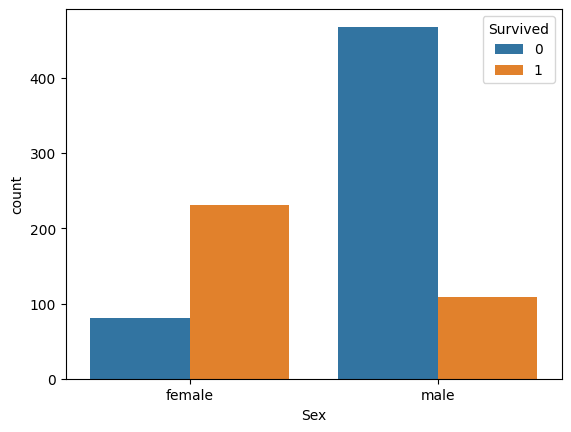

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data = df, x = 'Sex', hue = 'Survived')

Vendo a distribuição no gráfico, é percebido que mais mulheres sobreviveram do que homens. Isso acontece mesmo com uma qunatidade maior de homens a bordo.

Outra variável que pode mostrar distribuição diferente entre as suas categorias é a variável `Pclass`, que informa a classe do passageiro.

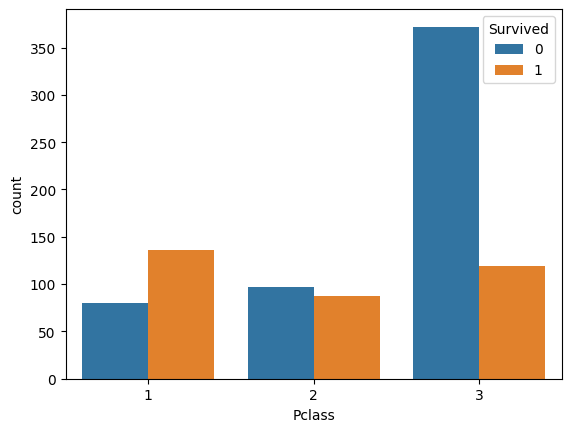

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data = df, x = 'Pclass', hue = 'Survived')

Novamente é percebido uma distribuição diferente entre as classes, com os passageiros da classe terceira classe tendo um alto risco de não sobreviver.

### Coluna `Name`

A coluna Name possui informações únicas. No entanto, há informações sobre títulos dos passageiros dentro dos nomes, o que pode ser útil para análises futuras.

In [28]:
df['Name']

0      Cumings, Mrs. John Bradley (Florence Briggs Th...
1                                 Heikkinen, Miss. Laina
2           Futrelle, Mrs. Jacques Heath (Lily May Peel)
3      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
4                    Nasser, Mrs. Nicholas (Adele Achem)
                             ...                        
886                               Sutehall, Mr. Henry Jr
887                 Rice, Mrs. William (Margaret Norton)
888                                Montvila, Rev. Juozas
889             Johnston, Miss. Catherine Helen "Carrie"
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [30]:
## Pega apenas o título de cada nome
titulo_com_nome = df['Name'].str.split(pat = ', ').str[1]
titulo_sem_nome = titulo_com_nome.str.split().str[0]
df['Title'] = titulo_sem_nome
df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilyMembers,Title
0,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,1,Mrs.
1,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,0,Miss.
2,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,1,Mrs.
3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,11.1333,S,2,Mrs.
4,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,30.0708,C,1,Mrs.


Com a coluna criada, pode-se comparar a taxa de mortalidade entre os diferentes títulos

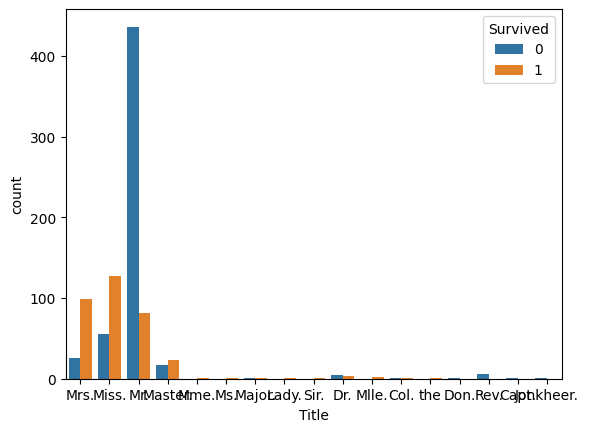

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data = df, x = 'Title', hue = 'Survived')

Ainda há um alto número de valores diferentes, é necessário procurar entender.

In [31]:
df['Title'].unique()

array(['Mrs.', 'Miss.', 'Mr.', 'Master.', 'Mme.', 'Ms.', 'Major.',
       'Lady.', 'Sir.', 'Dr.', 'Mlle.', 'Col.', 'the', 'Don.', 'Rev.',
       'Capt.', 'Jonkheer.'], dtype=object)

Apesar da possibilidade de agrupar, alguns títulos aparecem muito pouco. Além disso, os títulos também possuem ligação com o sexo do passageiro, o que poderia gerar comportamento indesejado do sistema. Por conta disso, essa coluna será removida das análises futuras.

In [32]:
colunas = ['Title', 'Name']

df = df.drop(columns = colunas)

In [33]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyMembers
0,1,1,female,38.0,71.2833,C,1
1,1,3,female,26.0,7.9250,S,0
2,1,1,female,35.0,53.1000,S,1
3,1,3,female,27.0,11.1333,S,2
4,1,2,female,14.0,30.0708,C,1


Com o final da análise dos nomes, é possível passar para a parte de Feature Engineering. O dataset começou com 9 colunas, sendo 1 a variável target e as outras as features do sistema. Agora, é necessário encodar as variáveis categóricas para que o modelo consiga entender a informação.

## Encodando as colunas categóricas

A última etapa antes da aplicação do modelo, é de aplicar o encoding nas variáveis categórias de texto. Essa etapa irá criar colunas novas para cada categoria. Para isso, será usado o método `get_dummies()`.

Para esse modelo, as variáveis numéricas não serão normalizadas pela variância.

In [33]:
categoricas = ['Sex','Embarked']

df_encoded = pd.get_dummies(data = df, columns = categoricas)
df_encoded

,Survived,Pclass,Age,Fare,FamilyMembers,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,1,38.000000,71.2833,1,1,0,1,0,0
1,1,3,26.000000,7.9250,0,1,0,0,0,1
2,1,1,35.000000,53.1000,1,1,0,0,0,1
3,1,3,27.000000,11.1333,2,1,0,0,0,1
4,1,2,14.000000,30.0708,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
884,0,3,25.000000,7.0500,0,0,1,0,0,1
885,0,3,39.000000,29.1250,5,1,0,0,1,0
886,0,2,27.000000,13.0000,0,0,1,0,0,1
887,0,3,30.626179,23.4500,3,1,0,0,0,1


Com as colunas encodadas, é possível iniciar os testes com modelos de machine learning

## Machine learning

Como a base de dados já trouxe datasets distintos para treino e teste, não será necessário dividir os dados já tratados. É necessário, no entanto, separar a variável target. O modelo de machine learning e sua avaliação estão disponíveis em um notebook separado.